# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   

   var_6m_price_off_peak_var  var_6m_price_peak_var  \
0                   0.000131           4.100838e-05   
1                   0.000003           1.217891e-03   
2                   0.000004           9.450150e-08   

   var_6m_price_mid_peak_var  var_6m_price_off_peak_fix  \
0                   0.000908                   2.086294   
1                   0.000000                   0.009482   
2                   0.000000                   0.000000   

   var_6m_price_peak_fix  var_6m_price_mid_peak_fix var_6m_price_off_peak  \
0              99.530517                  44.235794              2.086425   
1               0.000000                   0.000000              0.009485   
2               0.000000                   0.000000              0.000004   

   var_6m_price_peak  var_6m_price_mid_peak  churn  
0       9.953056e+01              44.236702      1  
1       1.217891e-03               0.000000      0  
2       9.450150e-08               0.000000      0  

[3 rows x 44 columns]

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000  
3                        0.162916  
4                       -0.000001

##Average price change

In [28]:
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [29]:
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [30]:
columns = [
    'id',
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  tenure_days  \
0      2015-11-01   2015-06-23               0.00  ...         1096   
1      2009-08-21   2015-08-31             189.95  ...         2566   
2      2010-04-16   2015-04-17              47.96  ...         2192   
3      2010-03-30   2015-03-31             240.04  ...         2192   
4      2010-01-13   2015-03-09             445.75  ...         2245   

   elec_gas_ratio  forecast_error_12m  prod_per_year  \
0             0.0                0.00       0.500000   
1          4660.0            -4470.05       0.142857   
2           544.0             -496.04       0.142857   
3          1584.0            -1343.96       0.142857   
4          4425.0            -3979.25       0.142857   

   off_peak_peak_var_mean_diff  peak_mid_peak_var_mean_diff  \
0                     0.024038                     0.034219   
1                     0.142485                     0.007124   
2                     0.082090                     0.088421   
3                     0.151210                     0.000000   
4                     0.020536                     0.030773   

  off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                        0.058257                    18.590255   
1                        0.149609                    44.311375   
2                        0.170512                    44.385450   
3                        0.151210                    44.400265   
4                        0.051309                    16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  
0                     7.450670                        26.040925  
1                     0.000000                        44.311375  
2                     0.000000                        44.385450  
3                     0.000000                        44.400265  
4                     8.137629                        24.412893  

[5 rows x 70 columns]

##Max price changes

In [31]:
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [32]:
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [33]:
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [17]:
date_cols = ['date_activ','date_end','date_modif_prod','date_renewal']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_weekday'] = df[col].dt.weekday

In [34]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                         0.058257                    18.590255   
1                         0.149609                    44.311375   
2                         0.170512                    44.385450   
3                         0.151210                    44.400265   
4                         0.051309                    16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                     7.450670                        26.040925   
1                     0.000000                        44.311375   
2                     0.000000                        44.385450   
3                     0.000000                        44.400265   
4                     8.137629                        24.412893   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                            0.060550                            0.085483   
1                            0.151367                            0.085483   
2                            0.084587                            0.089162   
3                            0.153133                            0.000000   
4                            0.022225                            0.033743   

  off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                               0.146033                           44.266930   
1                               0.151367                           44.444710   
2                               0.172468                           44.444710   
3                               0.153133                           44.444710   
4                               0.055866                           16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            8.145775                                44.26693  
1                            0.000000                                44.44471  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                            8.145775                                24.43733  

[5 rows x 76 columns]

Transforming date to Months

In [35]:
def convert_months(reference_date, df, column):
    """
    return number of whole months between two dates
    """
    dates = pd.to_datetime(df[column])

    year_diff  = reference_date.year  - dates.dt.year
    month_diff = reference_date.month - dates.dt.month

    # initial month count
    months = year_diff * 12 + month_diff

    # subtract 1 if the reference day hasn't been reached yet in that month
    months -= (reference_date.day < dates.dt.day).astype(int)

    return months

In [39]:
reference_date = datetime(2016, 1, 1)

df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [40]:
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0         0         54946                0               0.00   
1      4660             0                0             189.95   
2       544             0                0              47.96   
3      1584             0                0             240.04   
4      4425             0              526             445.75   

   forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
0                   0                       0.0                     1.78   
1                   0                       0.0                    16.27   
2                   0                       0.0                    38.72   
3                   0                       0.0                    19.83   
4                 526                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  off_peak_peak_var_max_monthly_diff  \
0                        0.114481  ...                            0.060550   
1                        0.145711  ...                            0.151367   
2                        0.165794  ...                            0.084587   
3                        0.146694  ...                            0.153133   
4                        0.116900  ...                            0.022225   

   peak_mid_peak_var_max_monthly_diff off_peak_mid_peak_var_max_monthly_diff  \
0                            0.085483                               0.146033   
1                            0.085483                               0.151367   
2                            0.089162                               0.172468   
3                            0.000000                               0.153133   
4                            0.033743                               0.055866   

   off_peak_peak_fix_max_monthly_diff  peak_mid_peak_fix_max_monthly_diff  \
0                           44.266930                            8.145775   
1                           44.444710                            0.000000   
2                           44.444710                            0.000000   
3                           44.444710                            0.000000   
4                           16.291555                            8.145775   

   off_peak_mid_peak_fix_max_monthly_diff  months_activ  months_to_end  \
0                                44.26693            30              6   
1                                44.44471            76              8   
2                                44.44471            68              4   
3                                44.44471            69              3   
4                                24.43733            71              3   

   months_modif_prod months_renewal  
0                  2              6  
1                 76              4  
2                 68              8  
3                 69              9  
4                 71              9  

[5 rows x 76 columns]

Has Gas

In [41]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

/tmp/ipython-input-3416244719.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])


churn
has_gas          
0        0.100544
1        0.081856

Customer tenure

In [18]:
df['tenure_days'] = (df['date_end'] - df['date_activ']).dt.days

Electricity vs Gas consumption ratio:

In [19]:
df['elec_gas_ratio'] = df['cons_12m'] / (df['cons_gas_12m'] + 1)

Forecast error

In [20]:
df['forecast_error_12m'] = df['forecast_cons_12m'] - df['cons_12m']

Active products per year of tenure:

In [21]:
df['prod_per_year'] = df['nb_prod_act'] / (df['num_years_antig'] + 1)

##Transforming categorical data

In [42]:
cols = ['channel_sales', 'origin_up']
min_count = 100

# get counts per category so we can filter out rare categories
value_counts = {col: df[col].value_counts() for col in cols}

df = pd.get_dummies(df, columns=cols, prefix=cols, dtype=int)

# drop rare columns
for col in cols:
    keep_cols = set(value_counts[col][value_counts[col] >= min_count].index.astype(str))

    dummy_cols = [c for c in df.columns if c.startswith(f"{col}_")]
    drop_cols = [c for c in dummy_cols if c.split(f"{col}_", 1)[1] not in keep_cols]
    df.drop(columns=drop_cols, inplace=True)



##Transforming numerical data

In [43]:
skewed_cols = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

print("Before log transform:")
print(df[skewed_cols].describe())

df[skewed_cols] = np.log10(df[skewed_cols] + 1)

print("After log transform:")
print(df[skewed_cols].describe())

Before log transform:
           cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   


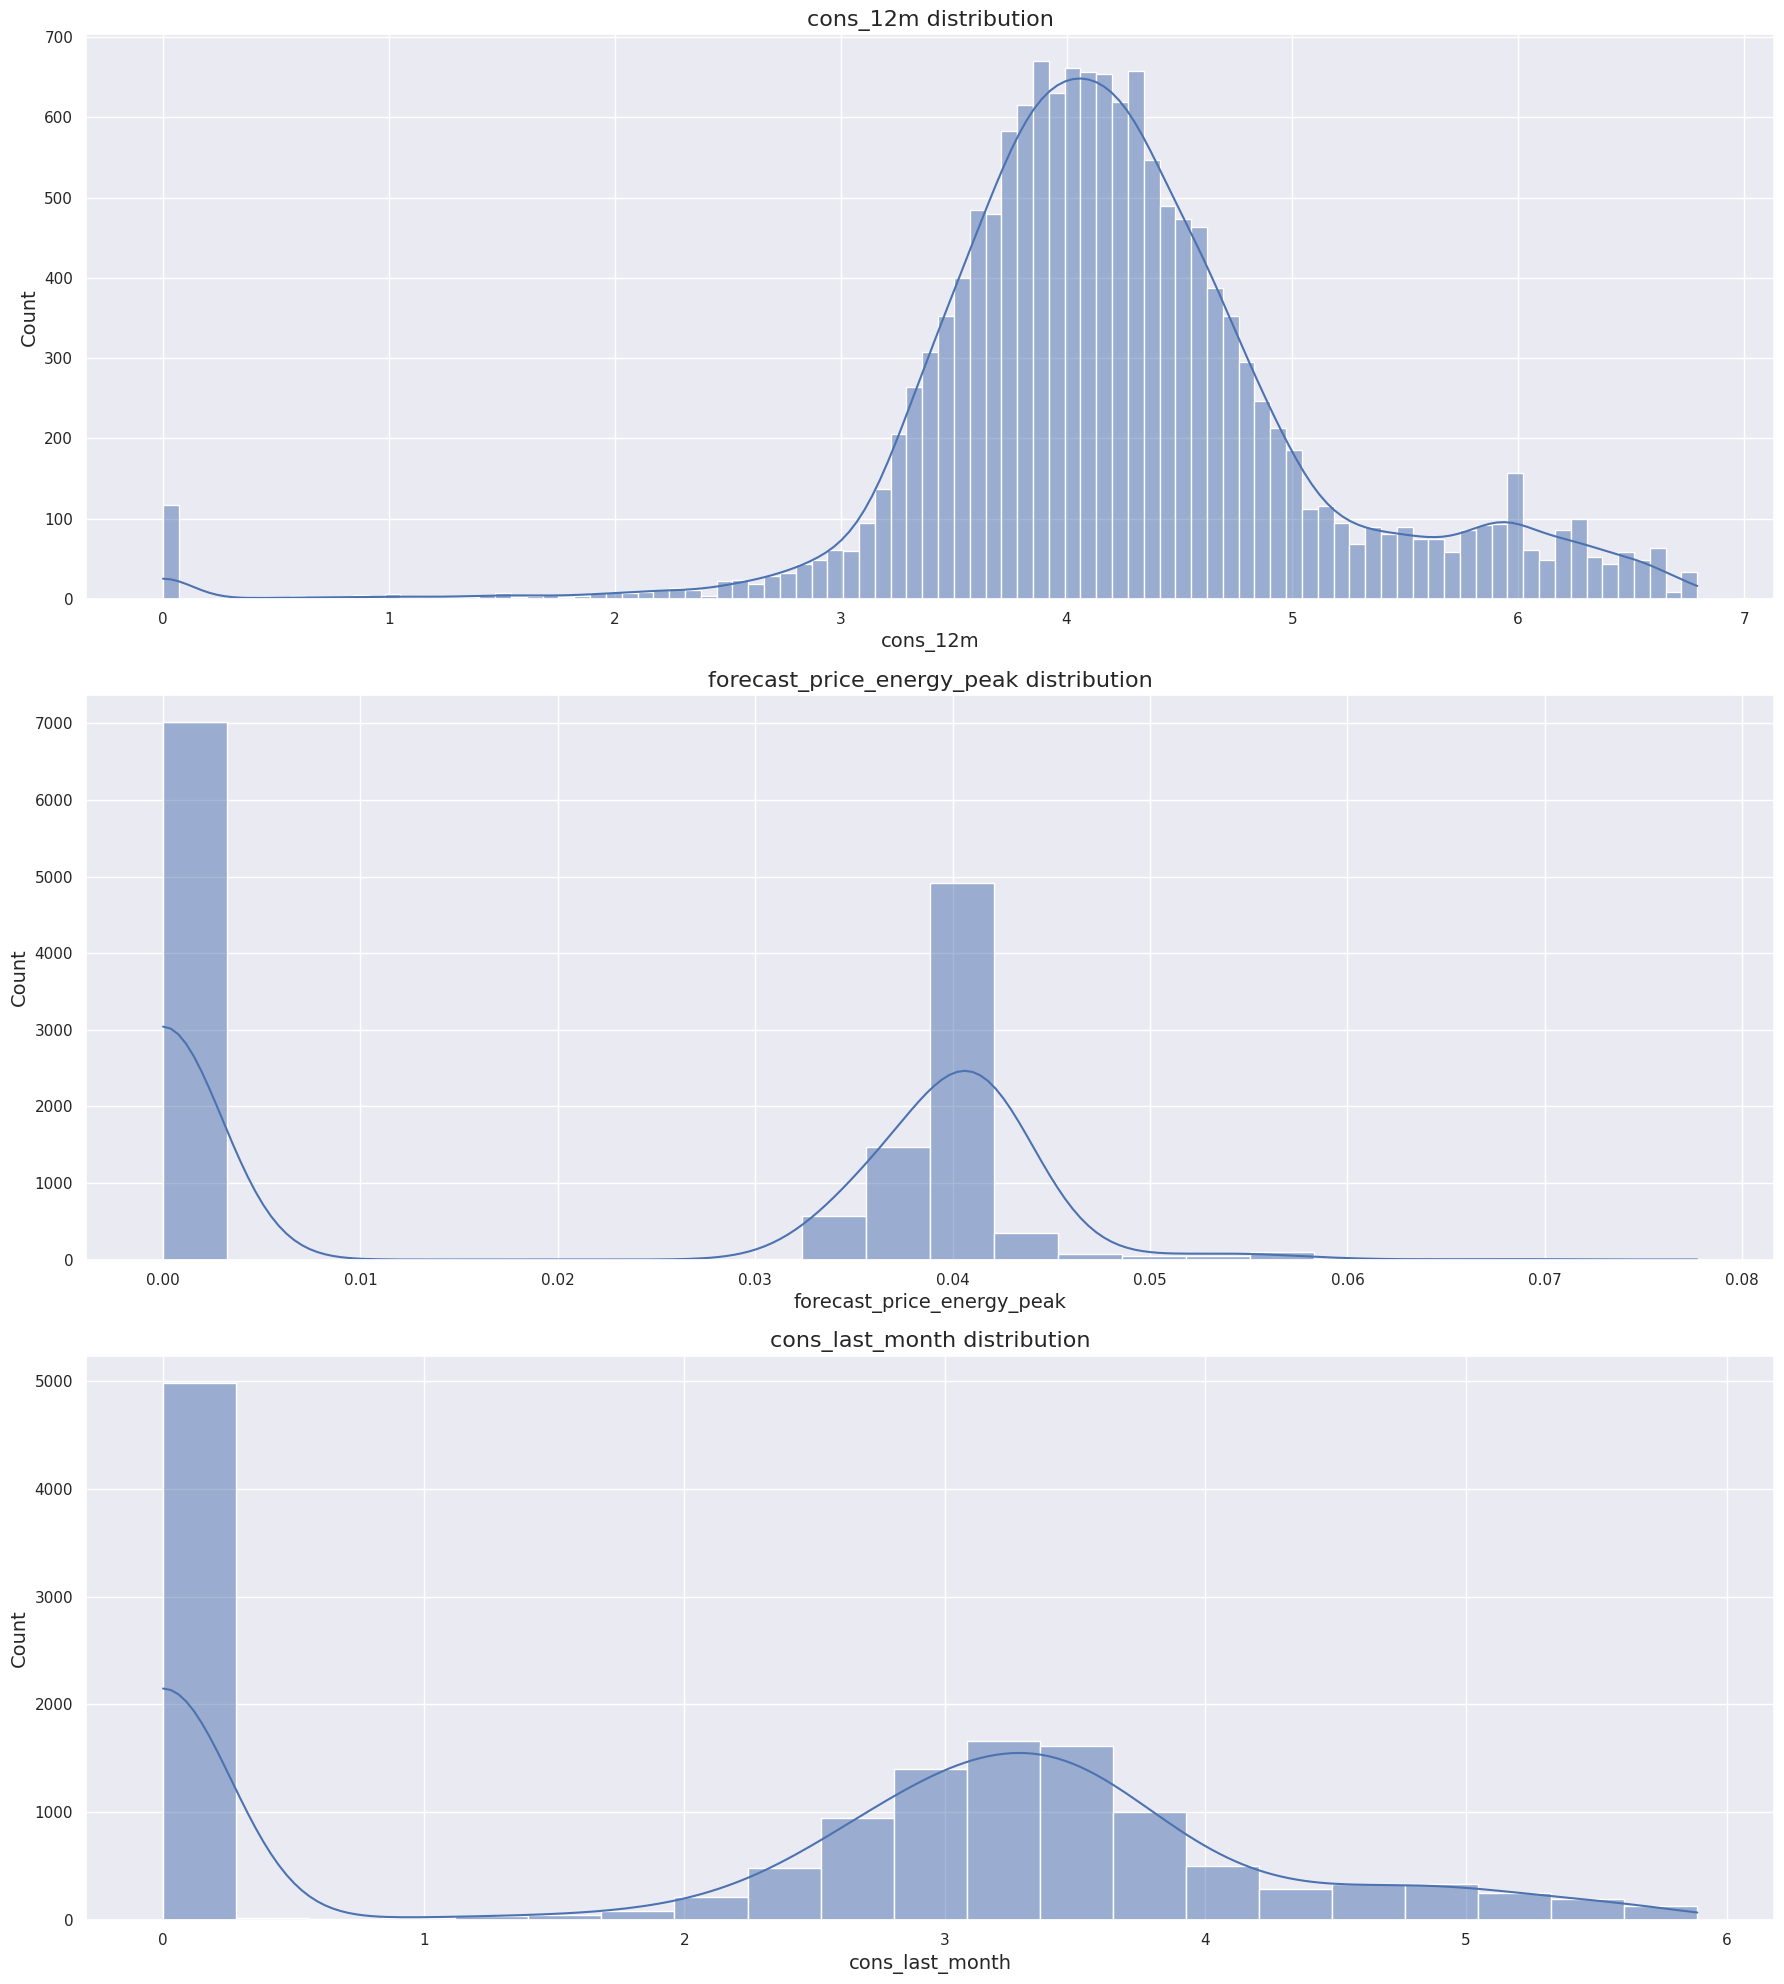

In [44]:
cols = ["cons_12m", "forecast_price_energy_peak", "cons_last_month"]

# Set up subplots
fig, axs = plt.subplots(nrows=len(cols), figsize=(18, 20))

# Loop through each column and plot
for ax, col in zip(axs, cols):
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f"{col} distribution", fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

##Correlations

In [45]:
correlation = df.drop(columns=['id']).corr()

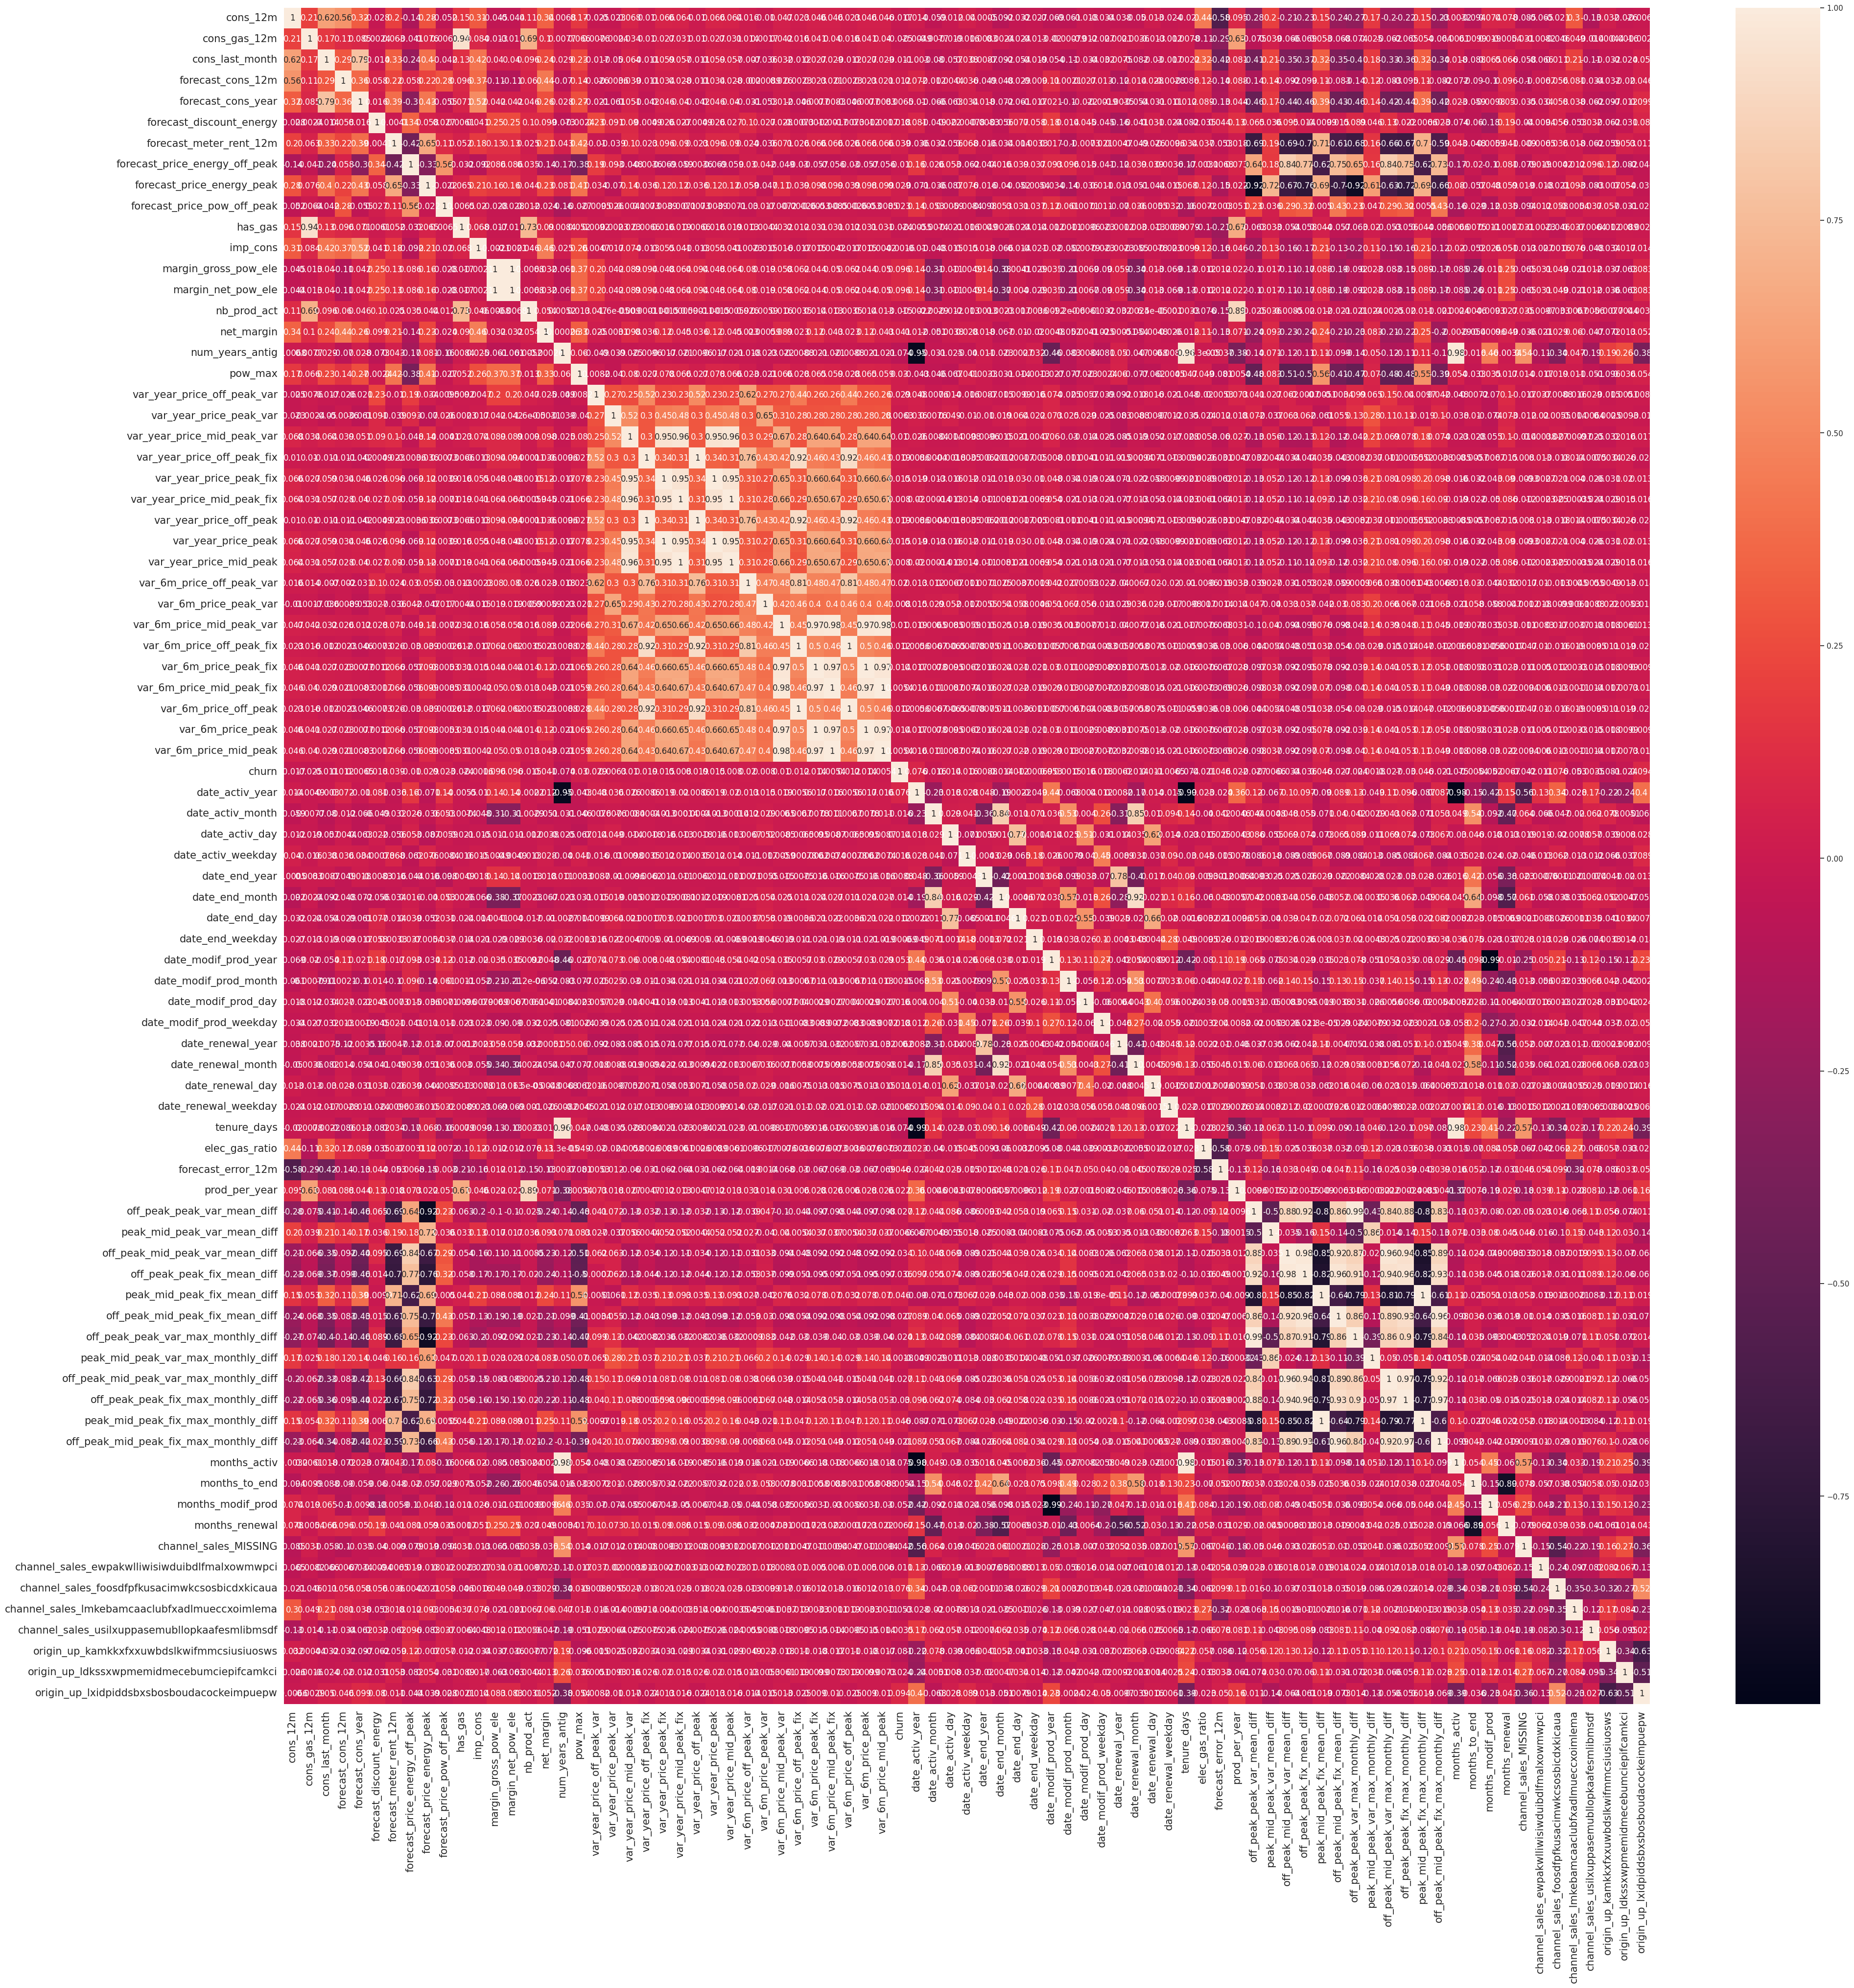

In [46]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

##Merging both datasets

In [47]:
full_df = df.merge(price_df, on='id', how='left')

In [48]:
full_df.head(3)

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57       0.0      4.739944              0.0   
1  24011ae4ebbe3035111d65fa7c15bc57       0.0      4.739944              0.0   
2  24011ae4ebbe3035111d65fa7c15bc57       0.0      4.739944              0.0   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0                0.0                 0.0                       0.0   
1                0.0                 0.0                       0.0   
2                0.0                 0.0                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                 0.444045                        0.047073   
1                 0.444045                        0.047073   
2                 0.444045                        0.047073   

   forecast_price_energy_peak  ...  \
0                    0.040659  ...   
1                    0.040659  ...   
2                    0.040659  ...   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           0   
2                                           0   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  price_date  price_off_peak_var  \
0                                           1  2015-01-01            0.125976   
1                                           1  2015-02-01            0.125976   
2                                           1  2015-03-01            0.125976   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0        0.103395            0.071536           40.565969       24.339581   
1        0.103395            0.071536           40.565969       24.339581   
2        0.103395            0.071536           40.565973       24.339578   

   price_mid_peak_fix  
0           16.226389  
1           16.226389  
2           16.226383  

[3 rows x 89 columns]

Price Sensitivity

In [49]:
full_df['price_off_peak_diff'] = full_df['var_6m_price_off_peak_var'] - full_df['forecast_price_energy_off_peak']

Churn risk factors

In [50]:
full_df['price_off_peak_avg'] = full_df[['var_6m_price_off_peak_var', 'var_6m_price_off_peak_fix']].mean(axis=1)

In [51]:
full_df.head(3)

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57       0.0      4.739944              0.0   
1  24011ae4ebbe3035111d65fa7c15bc57       0.0      4.739944              0.0   
2  24011ae4ebbe3035111d65fa7c15bc57       0.0      4.739944              0.0   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0                0.0                 0.0                       0.0   
1                0.0                 0.0                       0.0   
2                0.0                 0.0                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                 0.444045                        0.047073   
1                 0.444045                        0.047073   
2                 0.444045                        0.047073   

   forecast_price_energy_peak  ...  \
0                    0.040659  ...   
1                    0.040659  ...   
2                    0.040659  ...   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  price_date  price_off_peak_var  \
0                                           1  2015-01-01            0.125976   
1                                           1  2015-02-01            0.125976   
2                                           1  2015-03-01            0.125976   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0        0.103395            0.071536           40.565969       24.339581   
1        0.103395            0.071536           40.565969       24.339581   
2        0.103395            0.071536           40.565973       24.339578   

   price_mid_peak_fix  price_off_peak_diff  price_off_peak_avg  
0           16.226389            -0.046941            1.043213  
1           16.226389            -0.046941            1.043213  
2           16.226383            -0.046941            1.043213  

[3 rows x 91 columns]

In [52]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175149 entries, 0 to 175148
Data columns (total 91 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   id                                              175149 non-null  object        
 1   cons_12m                                        175149 non-null  float64       
 2   cons_gas_12m                                    175149 non-null  float64       
 3   cons_last_month                                 175149 non-null  float64       
 4   forecast_cons_12m                               175149 non-null  float64       
 5   forecast_cons_year                              175149 non-null  float64       
 6   forecast_discount_energy                        175149 non-null  float64       
 7   forecast_meter_rent_12m                         175149 non-null  float64       
 8   forecast_price_energy_off_peak    